## Western or Sci-fi? Can Deep Learning tell a cowboy from an astronaut?

This is an exercise for Lesson 1 of the Fast.ai "Practical Deep Learning for Coders" course, based on the notebook [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) by Jeremy Howard.



In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai fastbook duckduckgo_search difPy

## Step 1: Download images of posters of western and sci-fi movies

Let's start by downloading some movie posters using DuckDuckGo image search.

In [2]:
import fastbook
from fastbook import *

path = Path('categories')
print(path.resolve())

/kaggle/working/categories


In [60]:
# Clean the dataset if needed
if path.exists():
    shutil.rmtree(path)

In [3]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(search_images_ddg(term, max_images))

def search_and_download_images(searches, max_images=100, max_size=600):
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{o} movie posters', max_images))
        resize_images(path/o, max_size=max_size, dest=path/o)

In [4]:
search_and_download_images(['sci-fi', 'western'])

Searching for 'sci-fi movie posters'
Searching for 'western movie posters'


Let’s also download some test images that we’ll use for a later demo. Some of them are quite challenging.

In [5]:
download_url('https://a.1stdibscdn.com/unknown-prints-works-on-paper-large-original-vintage-sci-fi-movie-poster-for-terminator-arnold-schwarzenegger-for-sale/a_436/1547124219718/PC1203_master.jpg', 'test/terminator.jpg', show_progress=False)
download_url('https://image.tmdb.org/t/p/original/217ddlMrnXll436baw7y5ERmz3x.jpg', 'test/badland.jpg', show_progress=False)
download_url('https://image.tmdb.org/t/p/original/vUmpFXl8lgH4qyeLdaI2Xmw79UB.jpg', 'test/cowboys_aliens.jpg', show_progress=False)
download_url('https://i.etsystatic.com/20762201/r/il/a893b9/3202456262/il_fullxfull.3202456262_scdk.jpg', 'test/unforgiven.jpg', show_progress=False)
download_url('https://cdn.shopify.com/s/files/1/1057/4964/products/mad-max-vintage-movie-poster-original-40x60.jpg', 'test/mad-max.jpg', show_progress=False)
download_url('https://picfiles.alphacoders.com/349/thumb-1920-349599.jpg', 'test/interstellar.jpg', show_progress=False)

Path('test/interstellar.jpg')

## Step 2: Train our model

First let's cleanup our data. Some photos might not download correctly which could cause our model training to fail, so we'll remove them - `verify_images` checks if the image files can actually be opened:

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

The probability of getting the same poster twice on the dataset is non negligeble, and it may end on both test and validation sets, so to be safe(r) we're also checking for similar images using [difPy](https://github.com/elisemercury/Duplicate-Image-Finder). 

We're also trying to make sure that the images we're using to demo the model aren't part of the training set.

In [7]:
import difPy

dif = difPy.build([str((path/'sci-fi').resolve()), str((path/'western').resolve()), 'test'])
search = difPy.search(dif, similarity="similar")
print(search.result)
search.delete(silent_del=True)

difPy preparing files: [100%]
difPy searching files: [100%]
{'/kaggle/working/categories/sci-fi/dda20c9b-1e91-4437-837e-497ef484e7a1.jpg': [['/kaggle/working/categories/sci-fi/e90b8ce2-c921-4f8b-b24a-d9c48bbff1f1.jpg', 0.8262666666666667]], '/kaggle/working/categories/sci-fi/1966b164-cc27-4e49-b7e4-ba9c72447eab.jpg': [['/kaggle/working/categories/sci-fi/27cf97bf-e3ff-4a12-8cf3-a77a318293ed.jpg', 0.6508]], '/kaggle/working/categories/sci-fi/ca1b6803-487b-41eb-98dd-0804857fdbb7.jpg': [['test/terminator.jpg', 0.6857333333333333]], '/kaggle/working/categories/western/0c7b8b3a-e404-4410-8175-ac8106f7f744.jpg': [['/kaggle/working/categories/western/c8d527be-ee50-42ad-9b05-3711c3c7222b.jpg', 0.31666666666666665]], '/kaggle/working/categories/western/fdc65962-ea11-489f-9928-4ca1c7e0be33.jpg': [['/kaggle/working/categories/western/c390b80c-0e90-4e22-952a-957d02e8aae7.jpg', 0.7534666666666666]], '/kaggle/working/categories/western/74acc287-4d63-404c-ae21-5aeea3045c58.jpg': [['/kaggle/working/cat

We can now create the `DataLoaders` object that contains a *training set* and a *validation set*. Check out [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) for an explanation of each of the parameters passed to `DataBlock`.

Let's also peek into the dataset by showing a batch of 32 images.

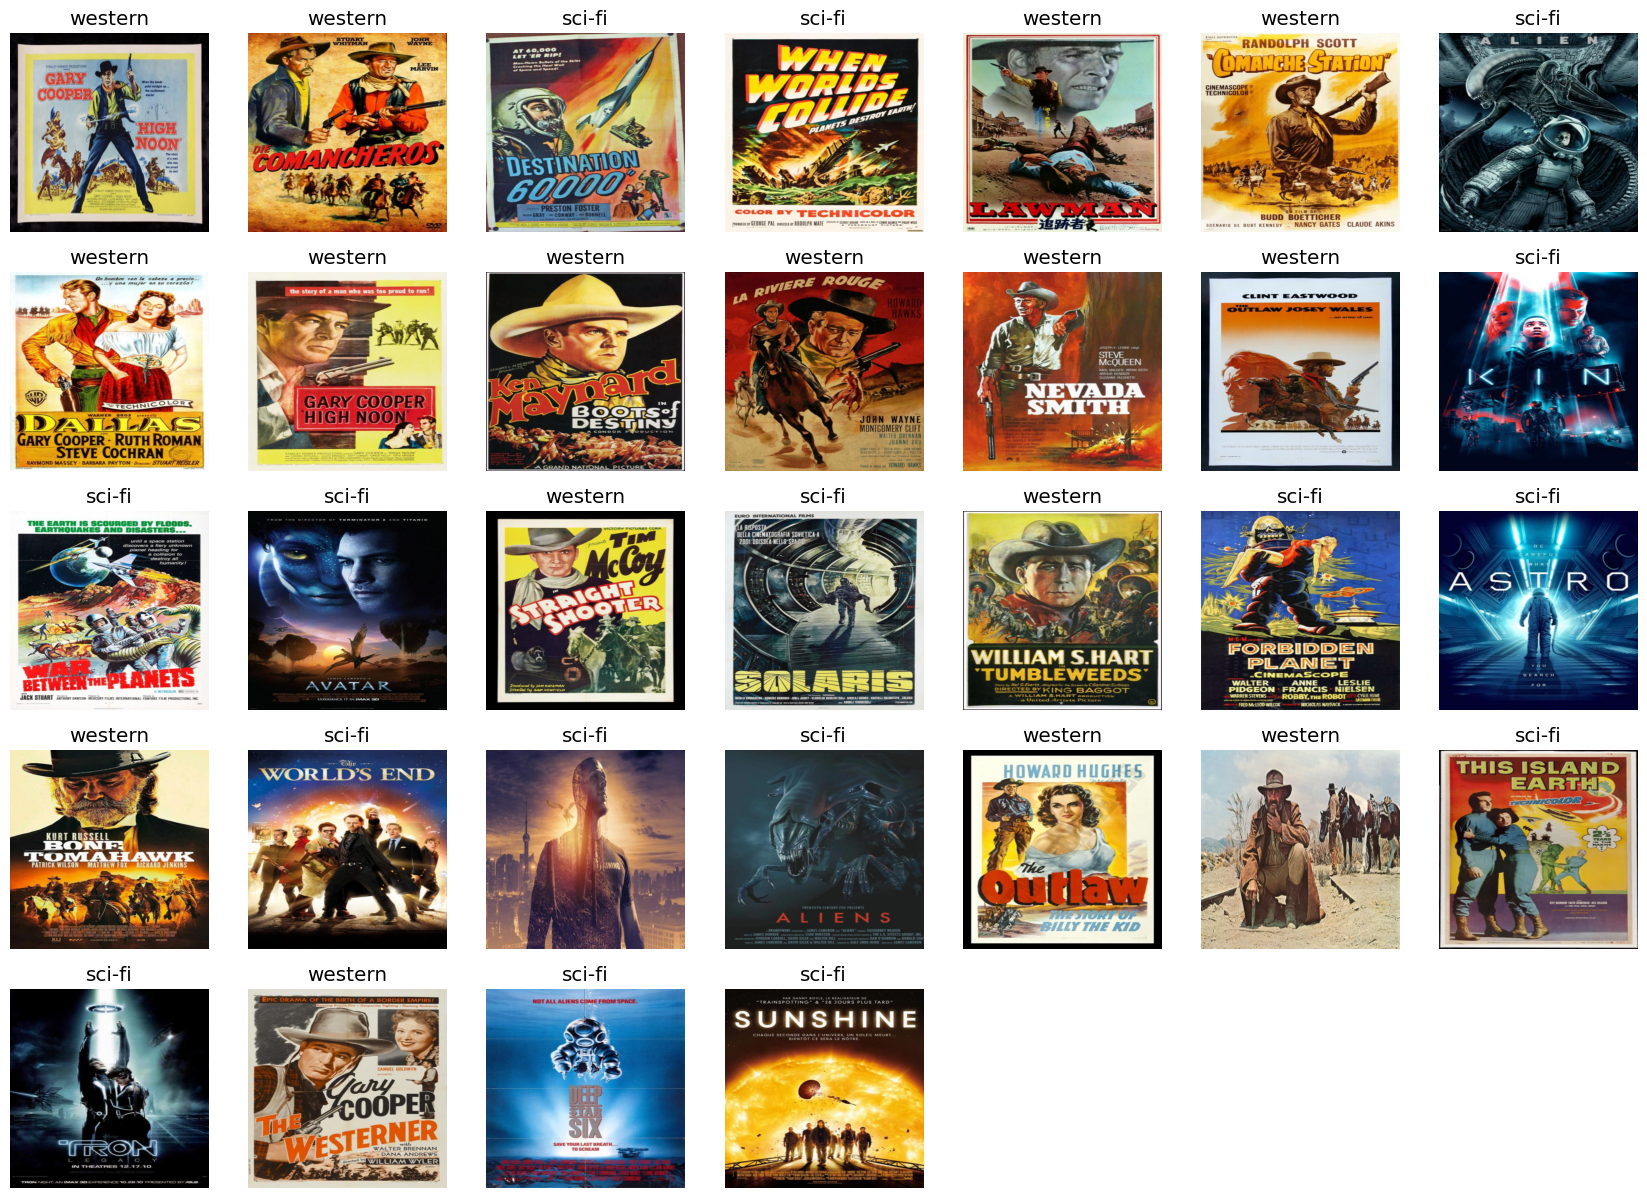

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(600, method='squish')]
).dataloaders(path, bs=32)
dls.show_batch(max_n=32)

And we're now ready to train our model. We'll fine-tune `resnet18`, the fastest widely used computer vision model.

> "Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

In [9]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s] 


## Step 3: Use our model
Let's try out our trained model on our hand-picked images.

In [11]:
def predict(image_name):
    category,_,probs = learn.predict(PILImage.create(image_name))
    print(f"This is a {category} movie.")
    print(f"Probability it's a scifi movie: {probs[0]:.4f}") 
    print(f"Probability it's a western movie: {probs[1]:.4f}") 

### Terminator
Definitely a Sci-fi movie.

This is a sci-fi movie.
Probability it's a scifi movie: 0.9694
Probability it's a western movie: 0.0306


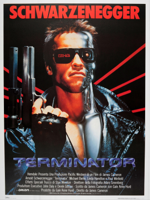

In [12]:
predict('test/terminator.jpg')
Image.open('test/terminator.jpg').to_thumb(200,200)

### Badland
Definitely a Western movie.

This is a western movie.
Probability it's a scifi movie: 0.0300
Probability it's a western movie: 0.9700


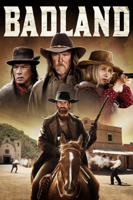

In [13]:
predict('test/badland.jpg')
Image.open('test/badland.jpg').to_thumb(200,200)

### Cowboys and Aliens 
Huh? That's a tough one 🤔 I would go 50/50.

This is a western movie.
Probability it's a scifi movie: 0.2094
Probability it's a western movie: 0.7906


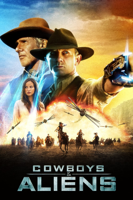

In [17]:
predict('test/cowboys_aliens.jpg')
Image.open('test/cowboys_aliens.jpg').to_thumb(200,200)

### Unforgiven
This is not always an easy one for the model. But the hat is definitively a giveaway 😄

This is a sci-fi movie.
Probability it's a scifi movie: 0.9585
Probability it's a western movie: 0.0415


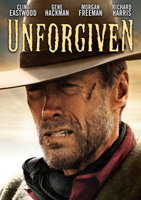

In [18]:
predict('test/unforgiven.jpg')
Image.open('test/unforgiven.jpg').to_thumb(200,200)

### Mad Max
I understand why the model gets confused with this one. Sometimes it classifies as Sci-fi, other times as Western depending on the training set.

This is a sci-fi movie.
Probability it's a scifi movie: 0.5906
Probability it's a western movie: 0.4094


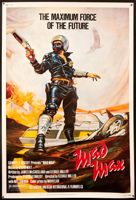

In [19]:
predict('test/mad-max.jpg')
Image.open('test/mad-max.jpg').to_thumb(200,200)

### Interstellar
Let's give the model a break, here's an no-brainer.

This is a sci-fi movie.
Probability it's a scifi movie: 1.0000
Probability it's a western movie: 0.0000


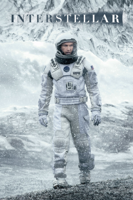

In [20]:
predict('test/interstellar.jpg')
Image.open('test/interstellar.jpg').to_thumb(200,200)

I think overall the results are pretty good! 

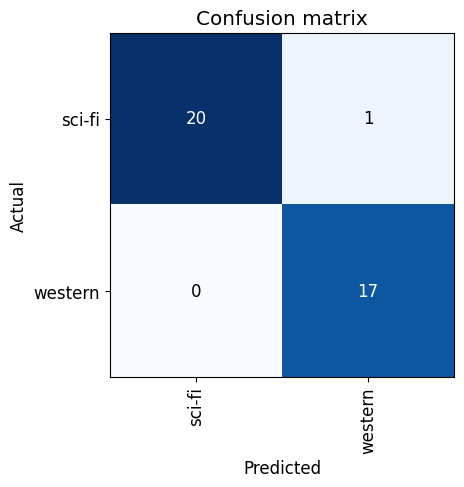

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

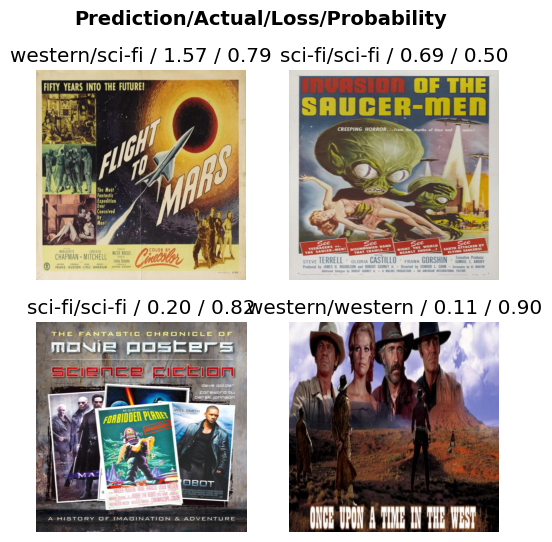

In [22]:
interp.plot_top_losses(4, nrows=2)